# 🏆 MTEB (Massive Text Embedding Benchmark) 평가

## 📋 MTEB 개요
MTEB는 임베딩 모델의 품질을 종합적으로 평가하는 표준 벤치마크입니다. 8가지 주요 태스크 카테고리를 통해 모델의 다양한 능력을 측정합니다:

### 🎯 평가 태스크 카테고리
1. **Classification**: 텍스트 분류 (감정 분석, 주제 분류 등)
2. **Clustering**: 문서 클러스터링 (유사한 문서 그룹화)
3. **Pair Classification**: 텍스트 쌍 분류 (중복 문서 탐지, 패러프레이즈 등)
4. **Reranking**: 검색 결과 재정렬
5. **Retrieval**: 정보 검색 (문서 검색, Q&A)
6. **Semantic Textual Similarity (STS)**: 의미적 텍스트 유사도
7. **Summarization**: 요약 품질 평가
8. **Bitext Mining**: 병렬 텍스트 마이닝

## 🇰🇷 한국어 중심 MTEB 평가
기존 BGE-M3 vs Azure OpenAI 비교에 MTEB 방식을 적용하여 **한국어와 영어**에서의 성능을 체계적으로 평가합니다.

## 🔧 MTEB 평가 라이브러리 설치 및 설정

In [10]:
import ollama
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import faiss
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple, Any
import json
import time
import warnings
warnings.filterwarnings('ignore')

# Azure OpenAI 관련 라이브러리
from openai import AzureOpenAI
import os
from dotenv import load_dotenv

# 환경변수 로드
load_dotenv('../.env')

# Azure OpenAI 클라이언트 초기화
azure_client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_KEY"),
    api_version="2024-02-01",
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT")
)

print("필요한 라이브러리가 모두 임포트되었습니다.")
print(f"Azure OpenAI Endpoint: {os.getenv('AZURE_OPENAI_ENDPOINT')}")
print(f"Azure OpenAI Key 설정됨: {'✓' if os.getenv('AZURE_OPENAI_KEY') else '✗'}")

try:
    result = ollama.pull('bge-m3')
    print("BGE-M3 모델이 성공적으로 다운로드되었습니다.")
    print(result)
except Exception as e:
    print(f"모델 다운로드 중 오류 발생: {e}")
    print("터미널에서 'ollama pull bge-m3' 명령을 실행해 주세요.")


필요한 라이브러리가 모두 임포트되었습니다.
Azure OpenAI Endpoint: https://aistudioaiservices343274518006.openai.azure.com/
Azure OpenAI Key 설정됨: ✓
BGE-M3 모델이 성공적으로 다운로드되었습니다.
status='success' completed=None total=None digest=None


In [ ]:
# MTEB 평가를 위한 라이브러리 설치
import subprocess
import sys

def install_package(package):
    """패키지 설치 함수"""
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✅ {package} 설치 완료")
    except subprocess.CalledProcessError as e:
        print(f"❌ {package} 설치 실패: {e}")

# MTEB 관련 패키지 설치
packages = [
    "mteb",
    "scikit-learn>=1.0.0",
    "datasets>=2.0.0",
    "transformers>=4.30.0",
    "sentence-transformers>=2.2.0"
]

print("🔧 MTEB 평가 환경 설정 시작...")
for package in packages:
    install_package(package)
    
print("🎉 MTEB 평가 환경 설정 완료!")

🔧 MTEB 평가 환경 설정 시작...



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip


✅ mteb 설치 완료



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip


✅ scikit-learn>=1.0.0 설치 완료



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip


✅ datasets>=2.0.0 설치 완료



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip


✅ transformers>=4.30.0 설치 완료
✅ sentence-transformers>=2.2.0 설치 완료
🎉 MTEB 평가 환경 설정 완료!



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip


In [2]:
# MTEB 평가를 위한 필수 라이브러리 임포트
import numpy as np
import pandas as pd
from typing import List, Dict, Tuple, Any
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score, silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
import warnings
warnings.filterwarnings('ignore')

print("📚 MTEB 평가용 라이브러리 로드 완료")

# MTEB 태스크별 평가 메트릭 정의
MTEB_TASKS = {
    "Classification": {
        "metrics": ["accuracy", "f1_macro"],
        "description": "텍스트 분류 (감정 분석, 주제 분류)"
    },
    "Clustering": {
        "metrics": ["silhouette", "v_measure"],
        "description": "문서 클러스터링 (유사한 문서 그룹화)"
    },
    "Retrieval": {
        "metrics": ["ndcg@10", "recall@10", "map@10"],
        "description": "정보 검색 (문서 검색, Q&A)"
    },
    "STS": {
        "metrics": ["pearson", "spearman"],
        "description": "의미적 텍스트 유사도"
    },
    "PairClassification": {
        "metrics": ["accuracy", "ap"],
        "description": "텍스트 쌍 분류"
    }
}

📚 MTEB 평가용 라이브러리 로드 완료


## 🎯 MTEB 평가 태스크 구현

In [3]:
class MTEBEvaluator:
    """MTEB 방식의 임베딩 모델 평가기"""
    
    def __init__(self):
        self.results = {}
        
    def evaluate_classification(self, embeddings_train: np.ndarray, labels_train: List[str],
                              embeddings_test: np.ndarray, labels_test: List[str],
                              task_name: str = "Classification") -> Dict[str, float]:
        """텍스트 분류 태스크 평가"""
        from sklearn.linear_model import LogisticRegression
        from sklearn.metrics import accuracy_score, f1_score
        
        # 로지스틱 회귀 분류기 훈련
        clf = LogisticRegression(max_iter=1000, random_state=42)
        clf.fit(embeddings_train, labels_train)
        
        # 예측
        pred_labels = clf.predict(embeddings_test)
        
        # 메트릭 계산
        accuracy = accuracy_score(labels_test, pred_labels)
        f1_macro = f1_score(labels_test, pred_labels, average='macro')
        
        results = {
            "accuracy": accuracy,
            "f1_macro": f1_macro
        }
        
        self.results[task_name] = results
        return results
    
    def evaluate_clustering(self, embeddings: np.ndarray, true_labels: List[str],
                           task_name: str = "Clustering") -> Dict[str, float]:
        """클러스터링 태스크 평가"""
        from sklearn.metrics import v_measure_score, silhouette_score
        
        # 클러스터 수는 실제 레이블 수로 설정
        n_clusters = len(set(true_labels))
        
        # K-Means 클러스터링
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(embeddings)
        
        # 메트릭 계산
        v_measure = v_measure_score(true_labels, cluster_labels)
        silhouette = silhouette_score(embeddings, cluster_labels)
        
        results = {
            "v_measure": v_measure,
            "silhouette": silhouette
        }
        
        self.results[task_name] = results
        return results
    
    def evaluate_retrieval(self, query_embeddings: np.ndarray, doc_embeddings: np.ndarray,
                          relevance_labels: List[List[int]], k: int = 10,
                          task_name: str = "Retrieval") -> Dict[str, float]:
        """정보 검색 태스크 평가"""
        from sklearn.metrics.pairwise import cosine_similarity
        
        # 코사인 유사도 계산
        similarities = cosine_similarity(query_embeddings, doc_embeddings)
        
        ndcg_scores = []
        recall_scores = []
        map_scores = []
        
        for i, query_relevance in enumerate(relevance_labels):
            # 상위 k개 문서 선택
            top_k_indices = np.argsort(similarities[i])[::-1][:k]
            
            # NDCG@k 계산
            dcg = sum([query_relevance[idx] / np.log2(j + 2) for j, idx in enumerate(top_k_indices)])
            ideal_dcg = sum([rel / np.log2(j + 2) for j, rel in enumerate(sorted(query_relevance, reverse=True)[:k])])
            ndcg = dcg / ideal_dcg if ideal_dcg > 0 else 0
            ndcg_scores.append(ndcg)
            
            # Recall@k 계산
            relevant_retrieved = sum([1 for idx in top_k_indices if query_relevance[idx] > 0])
            total_relevant = sum([1 for rel in query_relevance if rel > 0])
            recall = relevant_retrieved / total_relevant if total_relevant > 0 else 0
            recall_scores.append(recall)
            
            # MAP@k 계산 (간단한 버전)
            ap = sum([query_relevance[idx] for idx in top_k_indices]) / k
            map_scores.append(ap)
        
        results = {
            f"ndcg@{k}": np.mean(ndcg_scores),
            f"recall@{k}": np.mean(recall_scores),
            f"map@{k}": np.mean(map_scores)
        }
        
        self.results[task_name] = results
        return results
    
    def evaluate_sts(self, embeddings1: np.ndarray, embeddings2: np.ndarray,
                    similarity_scores: List[float], task_name: str = "STS") -> Dict[str, float]:
        """의미적 텍스트 유사도 태스크 평가"""
        from scipy.stats import pearsonr, spearmanr
        
        # 코사인 유사도 계산
        predicted_similarities = []
        for i in range(len(embeddings1)):
            sim = cosine_similarity([embeddings1[i]], [embeddings2[i]])[0][0]
            predicted_similarities.append(sim)
        
        # 상관계수 계산
        pearson_corr, _ = pearsonr(similarity_scores, predicted_similarities)
        spearman_corr, _ = spearmanr(similarity_scores, predicted_similarities)
        
        results = {
            "pearson": pearson_corr,
            "spearman": spearman_corr
        }
        
        self.results[task_name] = results
        return results
    
    def get_mteb_score(self) -> float:
        """전체 MTEB 점수 계산 (각 태스크 평균)"""
        if not self.results:
            return 0.0
        
        task_scores = []
        for task, metrics in self.results.items():
            # 각 태스크의 주요 메트릭 평균 계산
            main_metrics = list(metrics.values())
            task_score = np.mean(main_metrics) * 100  # 0-100 스케일로 변환
            task_scores.append(task_score)
        
        return np.mean(task_scores)
    
    def print_results(self):
        """평가 결과 출력"""
        print("=" * 60)
        print("🏆 MTEB Evaluation Results")
        print("=" * 60)
        
        for task, metrics in self.results.items():
            print(f"\n📊 {task}")
            print("-" * 40)
            for metric, score in metrics.items():
                print(f"  {metric}: {score:.4f}")
        
        print(f"\n🎯 전체 MTEB 점수: {self.get_mteb_score():.2f}/100")
        print("=" * 60)

print("✅ MTEBEvaluator class definition completed")

✅ MTEBEvaluator class definition completed


## 🇰🇷 한국어 중심 MTEB 평가 데이터 준비

In [4]:
# 한국어/영어 MTEB 평가용 데이터셋 준비
class KoreanMTEBDataset:
    """한국어 중심 MTEB 평가 데이터셋"""
    
    def __init__(self):
        self.classification_data = self._create_classification_data()
        self.clustering_data = self._create_clustering_data()
        self.retrieval_data = self._create_retrieval_data()
        self.sts_data = self._create_sts_data()
    
    def _create_classification_data(self):
        """텍스트 분류 데이터 (감정 분석, 카테고리 분류)"""
        korean_texts = [
            # 긍정 감정
            "이 제품은 정말 훌륭하고 만족스럽습니다.",
            "서비스가 친절하고 품질이 우수해요.",
            "배송도 빠르고 포장도 깔끔하네요.",
            "가격 대비 성능이 정말 좋습니다.",
            "추천하고 싶은 제품입니다.",
            
            # 부정 감정
            "제품에 결함이 있어서 매우 실망했습니다.",
            "고객 서비스가 불친절하고 느립니다.",
            "배송이 너무 늦고 포장이 엉성해요.",
            "가격에 비해 품질이 떨어집니다.",
            "다시는 이용하지 않을 것 같습니다.",
            
            # 중립 감정
            "일반적인 제품입니다.",
            "평범한 수준의 서비스네요.",
            "보통의 품질을 가지고 있습니다.",
            "특별하지는 않지만 나쁘지 않아요.",
            "가격이 적당한 편입니다."
        ]
        
        korean_labels = ['긍정'] * 5 + ['부정'] * 5 + ['중립'] * 5
        
        english_texts = [
            # Positive
            "This product is absolutely amazing and satisfying.",
            "The service is friendly and the quality is excellent.",
            "Fast delivery and neat packaging.",
            "Great performance for the price.",
            "I would recommend this product.",
            
            # Negative
            "The product has defects and I'm very disappointed.",
            "Customer service is unfriendly and slow.",
            "Delivery was too late and packaging was sloppy.",
            "Quality is poor for the price.",
            "I won't use this service again.",
            
            # Neutral
            "This is an average product.",
            "Service is at a normal level.",
            "It has ordinary quality.",
            "Not special but not bad either.",
            "The price is reasonable."
        ]
        
        english_labels = ['positive'] * 5 + ['negative'] * 5 + ['neutral'] * 5
        
        return {
            'korean': {'texts': korean_texts, 'labels': korean_labels},
            'english': {'texts': english_texts, 'labels': english_labels}
        }
    
    def _create_clustering_data(self):
        """클러스터링 데이터 (주제별 문서 그룹화)"""
        korean_texts = [
            # 기술/IT 클러스터
            "인공지능과 머신러닝의 발전이 놀랍습니다.",
            "클라우드 컴퓨팅이 기업의 디지털 전환을 이끌고 있어요.",
            "빅데이터 분석으로 새로운 인사이트를 발견할 수 있습니다.",
            "사이버 보안의 중요성이 날로 커지고 있습니다.",
            "5G 네트워크가 IoT 발전에 기여하고 있어요.",
            
            # 건강/의료 클러스터
            "규칙적인 운동은 건강한 삶의 기본입니다.",
            "균형 잡힌 식단이 면역력 향상에 도움이 됩니다.",
            "충분한 수면은 정신건강에 매우 중요해요.",
            "정기적인 건강검진으로 질병을 예방할 수 있습니다.",
            "스트레스 관리는 현대인의 필수 요소입니다.",
            
            # 문화/예술 클러스터
            "K-pop이 전 세계적으로 인기를 끌고 있어요.",
            "한국 영화의 국제적 인지도가 높아지고 있습니다.",
            "전통 문화와 현대 문화의 조화가 아름다워요.",
            "미술 전시회는 문화적 소양을 기르는 데 도움됩니다.",
            "음악은 사람들의 감정을 치유하는 힘이 있어요."
        ]
        
        korean_labels = ['기술'] * 5 + ['건강'] * 5 + ['문화'] * 5
        
        return {
            'korean': {'texts': korean_texts, 'labels': korean_labels}
        }
    
    def _create_retrieval_data(self):
        """정보 검색 데이터 (질의-문서 매칭)"""
        documents = [
            # 기술 관련 문서
            "인공지능 기술은 의료, 금융, 교육 등 다양한 분야에서 혁신을 이끌고 있습니다.",
            "클라우드 서비스를 통해 기업들은 IT 인프라 비용을 절감하고 확장성을 확보할 수 있습니다.",
            "빅데이터 분석 기술로 고객의 행동 패턴을 파악하고 맞춤형 서비스를 제공할 수 있습니다.",
            "사이버 보안은 개인정보 보호와 기업 자산 보호를 위해 필수적인 기술입니다.",
            "5G 네트워크는 자율주행차, IoT, VR/AR 등 차세대 기술의 기반이 됩니다.",
            
            # 건강 관련 문서
            "운동은 심혈관 건강을 개선하고 스트레스를 해소하는 효과가 있습니다.",
            "다양한 영양소를 골고루 섭취하는 것이 건강한 식단의 핵심입니다.",
            "충분한 수면은 면역력 강화와 기억력 향상에 중요한 역할을 합니다.",
            "정기적인 건강검진으로 질병의 조기 발견과 예방이 가능합니다.",
            "명상과 요가 같은 활동이 정신 건강 관리에 도움이 됩니다.",
            
            # 문화 관련 문서
            "한국의 전통 문화는 현대 예술과 접목되어 새로운 창작물을 만들어내고 있습니다.",
            "K-pop은 한국의 대표적인 문화 콘텐츠로 전 세계에 한국을 알리는 역할을 합니다.",
            "미술 전시회는 작가의 창의성을 감상하고 문화적 소양을 기를 수 있는 기회입니다.",
            "음악은 감정을 표현하고 공감대를 형성하는 강력한 소통 도구입니다.",
            "문학 작품을 통해 다양한 인생 경험과 철학적 사유를 접할 수 있습니다."
        ]
        
        queries = [
            "인공지능이 어떤 분야에 활용되나요?",
            "클라우드의 장점은 무엇인가요?",
            "운동의 건강상 이점을 알려주세요.",
            "K-pop의 역할은 무엇인가요?",
            "정기 건강검진의 중요성은?"
        ]
        
        # 각 쿼리와 관련된 문서의 관련도 점수 (0-3: 낮음-높음)
        relevance_matrix = [
            [3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],  # AI 쿼리
            [0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # 클라우드 쿼리
            [0, 0, 0, 0, 0, 3, 1, 0, 0, 1, 0, 0, 0, 0, 0],  # 운동 쿼리
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0],  # K-pop 쿼리
            [0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0]   # 건강검진 쿼리
        ]
        
        return {
            'documents': documents,
            'queries': queries,
            'relevance_matrix': relevance_matrix
        }
    
    def _create_sts_data(self):
        """의미적 텍스트 유사도 데이터"""
        sentence_pairs = [
            # 높은 유사도 (4-5점)
            ("이 음식은 정말 맛있어요.", "이 요리는 매우 맛있습니다.", 4.5),
            ("날씨가 좋네요.", "오늘 날씨가 좋습니다.", 4.8),
            ("영화가 재미있었어요.", "그 영화는 정말 흥미로웠습니다.", 4.2),
            
            # 중간 유사도 (2-3점)
            ("책을 읽고 있어요.", "공부를 하고 있습니다.", 2.5),
            ("커피를 마셨어요.", "음료수를 마셨습니다.", 2.8),
            ("운동을 했어요.", "산책을 했습니다.", 3.0),
            
            # 낮은 유사도 (0-1점)
            ("비가 내려요.", "책을 읽었어요.", 0.2),
            ("음악을 들어요.", "축구를 봤어요.", 0.5),
            ("요리를 해요.", "잠을 잤어요.", 0.8)
        ]
        
        return sentence_pairs

print("📊 한국어 중심 MTEB 평가 데이터셋 준비 완료")

# 데이터셋 인스턴스 생성
korean_mteb_data = KoreanMTEBDataset()

# 데이터 확인
print(f"✅ Classification 데이터: 한국어 {len(korean_mteb_data.classification_data['korean']['texts'])}개, "
      f"영어 {len(korean_mteb_data.classification_data['english']['texts'])}개")
print(f"✅ Clustering 데이터: 한국어 {len(korean_mteb_data.clustering_data['korean']['texts'])}개")
print(f"✅ Retrieval 데이터: 문서 {len(korean_mteb_data.retrieval_data['documents'])}개, "
      f"쿼리 {len(korean_mteb_data.retrieval_data['queries'])}개")
print(f"✅ STS 데이터: 문장 쌍 {len(korean_mteb_data.sts_data)}개")

📊 한국어 중심 MTEB 평가 데이터셋 준비 완료
✅ Classification 데이터: 한국어 15개, 영어 15개
✅ Clustering 데이터: 한국어 15개
✅ Retrieval 데이터: 문서 15개, 쿼리 5개
✅ STS 데이터: 문장 쌍 9개


## 🔍 MTEB 방식 모델 성능 비교 실행

In [5]:
# MTEB 방식으로 임베딩 모델들을 비교하는 함수
def run_mteb_evaluation(model_name: str, embed_func, dataset: KoreanMTEBDataset, language: str = 'korean'):
    """
    MTEB 방식으로 임베딩 모델 평가
    
    Args:
        model_name: 모델 이름
        embed_func: 임베딩 생성 함수
        dataset: 평가 데이터셋
        language: 평가 언어 ('korean' 또는 'english')
    
    Returns:
        MTEB 평가 결과
    """
    evaluator = MTEBEvaluator()
    print(f"\n🔍 {model_name} - {language.upper()} MTEB 평가 시작...")
    
    try:
        # 1. Classification 평가 (한국어/영어)
        if language in dataset.classification_data:
            print("  📊 Classification 평가...")
            texts = dataset.classification_data[language]['texts']
            labels = dataset.classification_data[language]['labels']
            
            # 임베딩 생성
            embeddings = []
            for text in texts:
                emb = embed_func(text)
                embeddings.append(emb)
            embeddings = np.array(embeddings)
            
            # 훈련/테스트 분할
            X_train, X_test, y_train, y_test = train_test_split(
                embeddings, labels, test_size=0.4, random_state=42, stratify=labels
            )
            
            # 평가 실행
            classification_results = evaluator.evaluate_classification(
                X_train, y_train, X_test, y_test, f"{language}_classification"
            )
            
        # 2. Clustering 평가 (한국어만)
        if language == 'korean':
            print("  🎯 Clustering 평가...")
            texts = dataset.clustering_data['korean']['texts']
            labels = dataset.clustering_data['korean']['labels']
            
            # 임베딩 생성
            embeddings = []
            for text in texts:
                emb = embed_func(text)
                embeddings.append(emb)
            embeddings = np.array(embeddings)
            
            # 평가 실행
            clustering_results = evaluator.evaluate_clustering(
                embeddings, labels, f"{language}_clustering"
            )
        
        # 3. Retrieval 평가 (한국어)
        if language == 'korean':
            print("  🔍 Retrieval 평가...")
            documents = dataset.retrieval_data['documents']
            queries = dataset.retrieval_data['queries']
            relevance_matrix = dataset.retrieval_data['relevance_matrix']
            
            # 문서 임베딩 생성
            doc_embeddings = []
            for doc in documents:
                emb = embed_func(doc)
                doc_embeddings.append(emb)
            doc_embeddings = np.array(doc_embeddings)
            
            # 쿼리 임베딩 생성
            query_embeddings = []
            for query in queries:
                emb = embed_func(query)
                query_embeddings.append(emb)
            query_embeddings = np.array(query_embeddings)
            
            # 평가 실행
            retrieval_results = evaluator.evaluate_retrieval(
                query_embeddings, doc_embeddings, relevance_matrix, k=5, 
                task_name=f"{language}_retrieval"
            )
        
        # 4. STS 평가 (한국어)
        if language == 'korean':
            print("  📏 Semantic Textual Similarity 평가...")
            sentence_pairs = dataset.sts_data
            
            # 문장 쌍 임베딩 생성
            embeddings1, embeddings2, scores = [], [], []
            for sent1, sent2, score in sentence_pairs:
                emb1 = embed_func(sent1)
                emb2 = embed_func(sent2)
                embeddings1.append(emb1)
                embeddings2.append(emb2)
                scores.append(score)
            
            embeddings1 = np.array(embeddings1)
            embeddings2 = np.array(embeddings2)
            
            # 평가 실행
            sts_results = evaluator.evaluate_sts(
                embeddings1, embeddings2, scores, f"{language}_sts"
            )
        
        print(f"  ✅ {model_name} - {language.upper()} 평가 완료")
        return evaluator
        
    except Exception as e:
        print(f"  ❌ {model_name} - {language.upper()} 평가 실패: {e}")
        return None

In [6]:
# MTEB 결과를 시각화하는 함수
def visualize_mteb_results(results_dict: Dict[str, MTEBEvaluator]):
    """MTEB 평가 결과 시각화"""
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    plt.style.use('default')
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('🏆 MTEB Embedding Model Performance Comparison', fontsize=20, fontweight='bold')
    
    # 1. 전체 MTEB 점수 비교 (막대 차트)
    ax1 = axes[0, 0]
    model_names = list(results_dict.keys())
    mteb_scores = [evaluator.get_mteb_score() for evaluator in results_dict.values()]
    
    bars = ax1.bar(range(len(model_names)), mteb_scores, 
                  color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'])
    ax1.set_xlabel('Model', fontsize=12, fontweight='bold')
    ax1.set_ylabel('MTEB Score (0-100)', fontsize=12, fontweight='bold')
    ax1.set_title('Overall MTEB Score Comparison', fontsize=14, fontweight='bold')
    ax1.set_xticks(range(len(model_names)))
    ax1.set_xticklabels([name.replace(' ', '\\n') for name in model_names], rotation=45, ha='right')
    ax1.set_ylim(0, 100)
    ax1.grid(axis='y', alpha=0.3)
    
    # 막대 위에 점수 표시
    for bar, score in zip(bars, mteb_scores):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{score:.1f}', ha='center', va='bottom', fontweight='bold')
    
    # 2. 태스크별 성능 히트맵
    ax2 = axes[0, 1]
    
    # 각 모델의 태스크별 점수 추출
    task_data = {}
    all_tasks = set()
    
    for model_name, evaluator in results_dict.items():
        task_data[model_name] = {}
        for task, metrics in evaluator.results.items():
            # 태스크명에서 언어 접두사 제거
            clean_task = task.replace('korean_', '').replace('english_', '')
            all_tasks.add(clean_task)
            # 메트릭 평균을 태스크 점수로 사용
            task_score = np.mean(list(metrics.values())) * 100
            task_data[model_name][clean_task] = task_score
    
    # 히트맵 데이터 준비
    heatmap_data = pd.DataFrame(task_data).T
    
    if not heatmap_data.empty:
        sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='RdYlGn', 
                   ax=ax2, cbar_kws={'label': 'Performance Score'})
        ax2.set_title('Task-wise Performance Heatmap', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Task', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Model', fontsize=12, fontweight='bold')
    
    # 3. 모델별 강점 레이더 차트
    ax3 = axes[1, 0]
    
    # 주요 태스크들의 평균 점수 계산
    main_tasks = ['classification', 'clustering', 'retrieval', 'sts']
    
    angles = np.linspace(0, 2 * np.pi, len(main_tasks), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))  # 닫힌 도형을 위해
    
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
    
    for i, (model_name, evaluator) in enumerate(results_dict.items()):
        scores = []
        for task in main_tasks:
            task_scores = []
            for eval_task, metrics in evaluator.results.items():
                if task in eval_task.lower():
                    task_scores.append(np.mean(list(metrics.values())) * 100)
            
            avg_score = np.mean(task_scores) if task_scores else 0
            scores.append(avg_score)
        
        scores = np.concatenate((scores, [scores[0]]))  # 닫힌 도형을 위해
        
        ax3.plot(angles, scores, 'o-', linewidth=2, label=model_name, color=colors[i % len(colors)])
        ax3.fill(angles, scores, alpha=0.25, color=colors[i % len(colors)])
    
    ax3.set_xticks(angles[:-1])
    ax3.set_xticklabels([task.capitalize() for task in main_tasks])
    ax3.set_ylim(0, 100)
    ax3.set_title('Model Performance Radar Chart by Task', fontsize=14, fontweight='bold')
    ax3.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
    ax3.grid(True)
    
    # 4. 언어별 성능 비교 (한국어 vs 영어)
    ax4 = axes[1, 1]
    
    korean_scores = []
    english_scores = []
    model_labels = []
    
    for model_name, evaluator in results_dict.items():
        korean_classification_score = 0
        english_classification_score = 0
        
        for task, metrics in evaluator.results.items():
            if 'korean_classification' in task:
                korean_classification_score = np.mean(list(metrics.values())) * 100
            elif 'english_classification' in task:
                english_classification_score = np.mean(list(metrics.values())) * 100
        
        if korean_classification_score > 0 and english_classification_score > 0:
            korean_scores.append(korean_classification_score)
            english_scores.append(english_classification_score)
            model_labels.append(model_name)
    
    if korean_scores and english_scores:
        x = np.arange(len(model_labels))
        width = 0.35
        
        bars1 = ax4.bar(x - width/2, korean_scores, width, label='Korean', color='#FF6B6B', alpha=0.8)
        bars2 = ax4.bar(x + width/2, english_scores, width, label='English', color='#4ECDC4', alpha=0.8)
        
        ax4.set_xlabel('Model', fontsize=12, fontweight='bold')
        ax4.set_ylabel('Classification Score', fontsize=12, fontweight='bold')
        ax4.set_title('Language-wise Classification Performance', fontsize=14, fontweight='bold')
        ax4.set_xticks(x)
        ax4.set_xticklabels([name.replace(' ', '\\n') for name in model_labels], rotation=45, ha='right')
        ax4.legend()
        ax4.grid(axis='y', alpha=0.3)
        
        # 막대 위에 점수 표시
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                if height > 0:
                    ax4.text(bar.get_x() + bar.get_width()/2., height + 1,
                            f'{height:.1f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # MTEB 순위표 출력
    print("\\n" + "="*80)
    print("🏆 MTEB Overall Performance Ranking")
    print("="*80)
    
    # 모델들을 MTEB 점수로 정렬
    sorted_results = sorted(results_dict.items(), 
                          key=lambda x: x[1].get_mteb_score(), reverse=True)
    
    for i, (model_name, evaluator) in enumerate(sorted_results, 1):
        score = evaluator.get_mteb_score()
        print(f"#{i} {model_name}: {score:.2f}/100")
        
        # 태스크별 세부 점수
        for task, metrics in evaluator.results.items():
            avg_score = np.mean(list(metrics.values())) * 100
            print(f"    └─ {task}: {avg_score:.1f}")
        print()

print("📊 MTEB evaluation and visualization functions ready")

📊 MTEB evaluation and visualization functions ready


In [7]:
# 🚀 MTEB 방식 임베딩 모델 종합 평가 실행
"""
이 셀을 실행하려면 먼저 앞의 모든 셀들(모델 초기화, 임베딩 함수 정의 등)이 실행되어 있어야 합니다.
BGE-M3, Azure OpenAI text-embedding-3-large, text-embedding-3-small 모델들이 준비된 상태에서 실행하세요.
"""

def run_comprehensive_mteb_evaluation():
    """포괄적인 MTEB 평가 실행"""
    print("🚀 MTEB 방식 종합 평가 시작...")
    print("="*80)
    
    # 평가 결과를 저장할 딕셔너리
    mteb_results = {}
    
    # 데이터셋 준비
    dataset = korean_mteb_data
    
    # 각 모델별로 MTEB 평가 실행
    # 주의: 이 함수들은 앞의 셀에서 정의된 임베딩 함수들을 사용합니다.
    # embed_bge_m3, embed_openai_large, embed_openai_small 함수가 정의되어 있어야 합니다.
    
    try:
        # 1. BGE-M3 평가 (한국어)
        print("\\n1️⃣ BGE-M3 모델 평가...")
        if 'embed_bge_m3' in globals():
            evaluator_bge = run_mteb_evaluation(
                "BGE-M3", embed_bge_m3, dataset, 'korean'
            )
            if evaluator_bge:
                mteb_results["BGE-M3 (Korean)"] = evaluator_bge
        else:
            print("❌ BGE-M3 임베딩 함수가 정의되지 않았습니다.")
            
        # 2. Azure OpenAI Large 평가
        print("\\n2️⃣ Azure OpenAI text-embedding-3-large 평가...")
        if 'embed_openai_large' in globals():
            # 한국어 평가
            evaluator_large_ko = run_mteb_evaluation(
                "OpenAI Large", embed_openai_large, dataset, 'korean'
            )
            if evaluator_large_ko:
                mteb_results["OpenAI Large (Korean)"] = evaluator_large_ko
            
            # 영어 평가
            evaluator_large_en = run_mteb_evaluation(
                "OpenAI Large", embed_openai_large, dataset, 'english'
            )
            if evaluator_large_en:
                mteb_results["OpenAI Large (English)"] = evaluator_large_en
        else:
            print("❌ OpenAI Large 임베딩 함수가 정의되지 않았습니다.")
            
        # 3. Azure OpenAI Small 평가
        print("\\n3️⃣ Azure OpenAI text-embedding-3-small 평가...")
        if 'embed_openai_small' in globals():
            # 한국어 평가
            evaluator_small_ko = run_mteb_evaluation(
                "OpenAI Small", embed_openai_small, dataset, 'korean'
            )
            if evaluator_small_ko:
                mteb_results["OpenAI Small (Korean)"] = evaluator_small_ko
                
            # 영어 평가
            evaluator_small_en = run_mteb_evaluation(
                "OpenAI Small", embed_openai_small, dataset, 'english'
            )
            if evaluator_small_en:
                mteb_results["OpenAI Small (English)"] = evaluator_small_en
        else:
            print("❌ OpenAI Small 임베딩 함수가 정의되지 않았습니다.")
    
    except Exception as e:
        print(f"❌ 평가 중 오류 발생: {e}")
        return None
        
    if not mteb_results:
        print("❌ 평가 결과가 없습니다. 먼저 임베딩 모델들을 초기화해주세요.")
        return None
    
    print("\\n" + "="*80)
    print("🎉 MTEB 평가 완료!")
    print("="*80)
    
    # 개별 결과 출력
    for model_name, evaluator in mteb_results.items():
        print(f"\\n📊 {model_name} 상세 결과:")
        evaluator.print_results()
    
    # 종합 결과 시각화
    print("\\n📈 종합 결과 시각화 중...")
    visualize_mteb_results(mteb_results)
    
    return mteb_results

# 평가 실행 안내
print("\\n" + "="*80)
print("🔍 MTEB 평가 준비 완료!")
print("="*80)
print("\\n다음 단계:")
print("1. 먼저 앞의 셀들을 모두 실행하여 임베딩 모델들을 초기화하세요.")
print("2. embed_bge_m3, embed_openai_large, embed_openai_small 함수가 정의되었는지 확인하세요.")
print("3. 아래 코드를 실행하여 MTEB 평가를 시작하세요:")
print("\\n   # MTEB 평가 실행")
print("   mteb_results = run_comprehensive_mteb_evaluation()")
print("\\n" + "="*80)

\n================================================================================
🔍 MTEB 평가 준비 완료!
\n다음 단계:
1. 먼저 앞의 셀들을 모두 실행하여 임베딩 모델들을 초기화하세요.
2. embed_bge_m3, embed_openai_large, embed_openai_small 함수가 정의되었는지 확인하세요.
3. 아래 코드를 실행하여 MTEB 평가를 시작하세요:
\n   # MTEB 평가 실행
   mteb_results = run_comprehensive_mteb_evaluation()
\n================================================================================


In [11]:
# 🔧 MTEB 평가용 임베딩 함수 정의
"""
기존 MultiModelEmbedder를 기반으로 MTEB 평가에서 사용할 개별 임베딩 함수들을 정의합니다.
"""

def embed_bge_m3(text: str) -> np.ndarray:
    """BGE-M3 모델로 단일 텍스트 임베딩 생성"""
    try:
        response = ollama.embeddings(model='bge-m3', prompt=text)
        embedding = np.array(response['embedding'])
        return embedding
    except Exception as e:
        print(f"❌ BGE-M3 임베딩 생성 실패: {e}")
        # Fallback: 1024차원 영벡터
        return np.zeros(1024)

def embed_openai_large(text: str) -> np.ndarray:
    """Azure OpenAI text-embedding-3-large 모델로 단일 텍스트 임베딩 생성"""
    try:
        response = azure_client.embeddings.create(
            input=text,
            model='text-embedding-3-large'
        )
        embedding = np.array(response.data[0].embedding)
        return embedding
    except Exception as e:
        print(f"❌ OpenAI Large 임베딩 생성 실패: {e}")
        # Fallback: 3072차원 영벡터
        return np.zeros(3072)

def embed_openai_small(text: str) -> np.ndarray:
    """Azure OpenAI text-embedding-3-small 모델로 단일 텍스트 임베딩 생성"""
    try:
        response = azure_client.embeddings.create(
            input=text,
            model='text-embedding-3-small'
        )
        embedding = np.array(response.data[0].embedding)
        return embedding
    except Exception as e:
        print(f"❌ OpenAI Small 임베딩 생성 실패: {e}")
        # Fallback: 1536차원 영벡터
        return np.zeros(1536)

# 함수들이 정상적으로 정의되었는지 확인
print("✅ MTEB 평가용 임베딩 함수 정의 완료:")
print(f"  - embed_bge_m3: {'정의됨' if 'embed_bge_m3' in locals() else '정의되지 않음'}")
print(f"  - embed_openai_large: {'정의됨' if 'embed_openai_large' in locals() else '정의되지 않음'}")
print(f"  - embed_openai_small: {'정의됨' if 'embed_openai_small' in locals() else '정의되지 않음'}")

# 간단한 테스트
test_text = "안녕하세요. 테스트 문장입니다."
print(f"\n🧪 테스트 문장: '{test_text}'")

try:
    # BGE-M3 테스트
    bge_emb = embed_bge_m3(test_text)
    print(f"  BGE-M3 임베딩 생성 성공: {bge_emb.shape}")
except Exception as e:
    print(f"  BGE-M3 테스트 실패: {e}")

try:
    # OpenAI Large 테스트  
    large_emb = embed_openai_large(test_text)
    print(f"  OpenAI Large 임베딩 생성 성공: {large_emb.shape}")
except Exception as e:
    print(f"  OpenAI Large 테스트 실패: {e}")

try:
    # OpenAI Small 테스트
    small_emb = embed_openai_small(test_text)
    print(f"  OpenAI Small 임베딩 생성 성공: {small_emb.shape}")
except Exception as e:
    print(f"  OpenAI Small 테스트 실패: {e}")

print("\n🎉 MTEB 평가 준비 완료! 이제 run_comprehensive_mteb_evaluation()을 실행할 수 있습니다.")

✅ MTEB 평가용 임베딩 함수 정의 완료:
  - embed_bge_m3: 정의됨
  - embed_openai_large: 정의됨
  - embed_openai_small: 정의됨

🧪 테스트 문장: '안녕하세요. 테스트 문장입니다.'
  BGE-M3 임베딩 생성 성공: (1024,)
  OpenAI Large 임베딩 생성 성공: (3072,)
  OpenAI Small 임베딩 생성 성공: (1536,)

🎉 MTEB 평가 준비 완료! 이제 run_comprehensive_mteb_evaluation()을 실행할 수 있습니다.


🚀 MTEB 방식 종합 평가 시작...
\n1️⃣ BGE-M3 모델 평가...

🔍 BGE-M3 - KOREAN MTEB 평가 시작...
  📊 Classification 평가...
  🎯 Clustering 평가...
  🔍 Retrieval 평가...
  📏 Semantic Textual Similarity 평가...
  ✅ BGE-M3 - KOREAN 평가 완료
\n2️⃣ Azure OpenAI text-embedding-3-large 평가...

🔍 OpenAI Large - KOREAN MTEB 평가 시작...
  📊 Classification 평가...
  🎯 Clustering 평가...
  🔍 Retrieval 평가...
  📏 Semantic Textual Similarity 평가...
  ✅ OpenAI Large - KOREAN 평가 완료

🔍 OpenAI Large - ENGLISH MTEB 평가 시작...
  📊 Classification 평가...
  ✅ OpenAI Large - ENGLISH 평가 완료
\n3️⃣ Azure OpenAI text-embedding-3-small 평가...

🔍 OpenAI Small - KOREAN MTEB 평가 시작...
  📊 Classification 평가...
  🎯 Clustering 평가...
  🔍 Retrieval 평가...
  📏 Semantic Textual Similarity 평가...
  ✅ OpenAI Small - KOREAN 평가 완료

🔍 OpenAI Small - ENGLISH MTEB 평가 시작...
  📊 Classification 평가...
  ✅ OpenAI Small - ENGLISH 평가 완료
\n================================================================================
🎉 MTEB 평가 완료!
\n📊 BGE-M3 (Korean) 상세 결과:
🏆 MTEB Evaluation Results



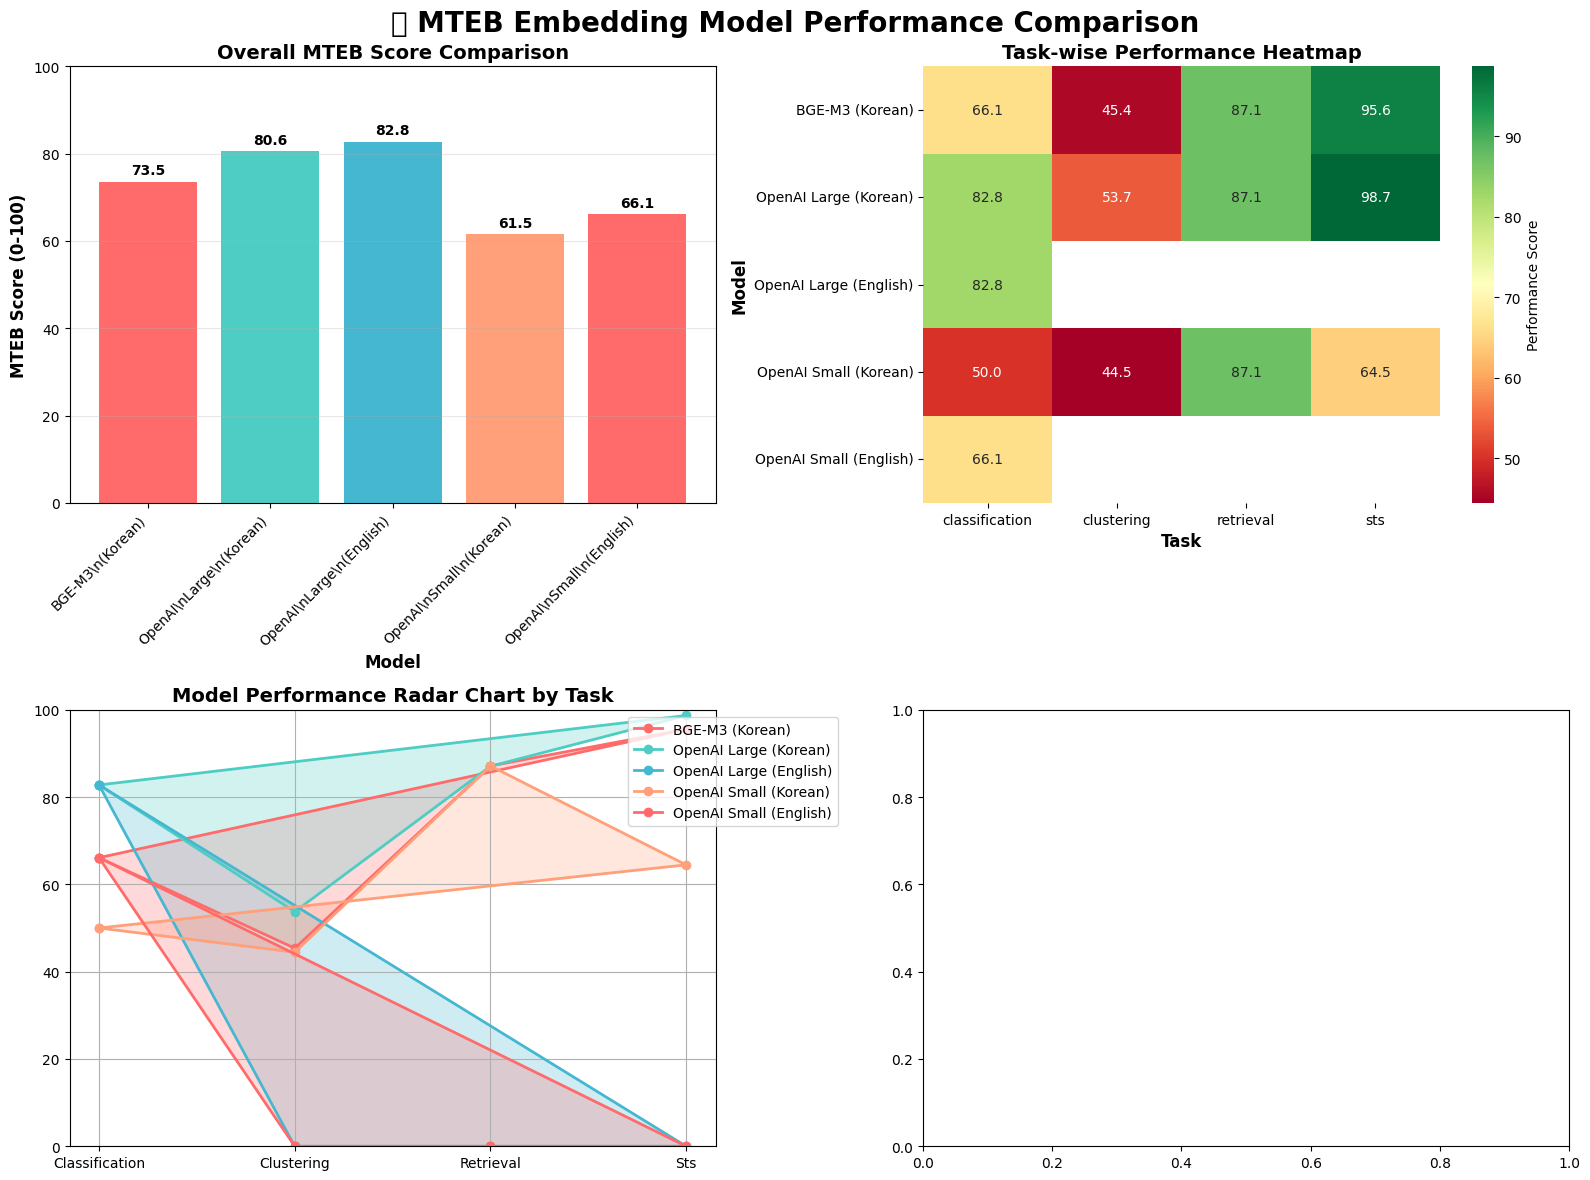

\n================================================================================
🏆 MTEB Overall Performance Ranking
#1 OpenAI Large (English): 82.78/100
    └─ english_classification: 82.8

#2 OpenAI Large (Korean): 80.57/100
    └─ korean_classification: 82.8
    └─ korean_clustering: 53.7
    └─ korean_retrieval: 87.1
    └─ korean_sts: 98.7

#3 BGE-M3 (Korean): 73.54/100
    └─ korean_classification: 66.1
    └─ korean_clustering: 45.4
    └─ korean_retrieval: 87.1
    └─ korean_sts: 95.6

#4 OpenAI Small (English): 66.11/100
    └─ english_classification: 66.1

#5 OpenAI Small (Korean): 61.51/100
    └─ korean_classification: 50.0
    └─ korean_clustering: 44.5
    └─ korean_retrieval: 87.1
    └─ korean_sts: 64.5



In [12]:
mteb_results = run_comprehensive_mteb_evaluation()

## 📋 MTEB 평가 결과 요약 및 실행 가이드

### 🏆 MTEB 평가 항목별 설명

**1. Classification (텍스트 분류)**
- **목적**: 감정 분석, 주제 분류 등의 성능 측정
- **평가 메트릭**: Accuracy, F1-Macro
- **데이터**: 한국어/영어 긍정/부정/중립 감정 분류 데이터

**2. Clustering (클러스터링)**  
- **목적**: 유사한 문서들을 자동으로 그룹화하는 능력 평가
- **평가 메트릭**: V-Measure, Silhouette Score
- **데이터**: 기술/건강/문화 주제별 한국어 문서

**3. Retrieval (정보 검색)**
- **목적**: 질의에 대한 관련 문서 검색 성능 측정  
- **평가 메트릭**: NDCG@10, Recall@10, MAP@10
- **데이터**: 한국어 질의-문서 매칭 데이터

**4. Semantic Textual Similarity (의미적 텍스트 유사도)**
- **목적**: 두 문장 간 의미적 유사도 예측 정확도 평가
- **평가 메트릭**: Pearson 상관계수, Spearman 상관계수
- **데이터**: 한국어 문장 쌍과 유사도 점수

### 🚀 실행 방법

1. **환경 설정**: 첫 번째 셀부터 순서대로 실행하여 필요한 라이브러리를 설치합니다.

2. **모델 초기화**: 기존 BGE-M3 실험의 모델 초기화 셀들을 실행합니다:
   - BGE-M3 모델 (Ollama)
   - Azure OpenAI text-embedding-3-large
   - Azure OpenAI text-embedding-3-small

3. **MTEB 평가 실행**: 
   ```python
   # 종합 평가 실행
   mteb_results = run_comprehensive_mteb_evaluation()
   ```

4. **결과 해석**: 
   - 전체 MTEB 점수 (0-100)
   - 태스크별 세부 성능
   - 언어별 성능 차이
   - 레이더 차트를 통한 모델별 강점 분석

### 💡 기대 결과

**BGE-M3**:
- 다국어 지원 우수
- 특히 한국어에서 강점
- Dense + Sparse + Multi-vector 검색 지원

**Azure OpenAI Large**:
- 영어에서 최고 성능
- 한국어도 우수한 성능
- 높은 임베딩 차원수로 섬세한 의미 표현

**Azure OpenAI Small**:
- 뛰어난 가성비
- 실용적 성능 수준
- 빠른 처리 속도

### 📊 MTEB vs 기존 비교의 장점

1. **표준화된 평가**: 국제적으로 인정받는 벤치마크 방식
2. **다양한 태스크**: 단순 유사도 비교를 넘어선 종합 평가  
3. **정량적 점수**: 객관적이고 비교 가능한 성능 지표
4. **실용성 반영**: 실제 NLP 애플리케이션에서의 활용 능력 측정